# Traditional transfer learning tutorial
This is a tutorial notebook for traditional transfer learning (i.e., non-deep learning).

We'll implement two algorithms:
- **TCA** (Transfer Component Analysis) [1]
- **BDA** (Balanced Distribution Adaptation) [2]

Then, we test the algorithms using **Office-Caltech10** SURF dataset. This dataset will be downloaded automatically in this tutorial.

References:

[1] Pan S J, Tsang I W, Kwok J T, et al. Domain adaptation via transfer component analysis[J]. IEEE Transactions on Neural Networks, 2010, 22(2): 199-210.

[2] Wang J, Chen Y, Hao S, et al. Balanced distribution adaptation for transfer learning[C]//2017 IEEE international conference on data mining (ICDM). IEEE, 2017: 1129-1134.

## Download and unzip dataset
You can also download the dataset from here: https://github.com/jindongwang/transferlearning/tree/master/data#office-caltech10

In [27]:
!wget https://transferlearningdrive.blob.core.windows.net/teamdrive/dataset/office-caltech-surf.zip
!unzip office-caltech-surf.zip

zsh:1: command not found: wget
unzip:  cannot find or open office-caltech-surf.zip, office-caltech-surf.zip.zip or office-caltech-surf.zip.ZIP.


## Import libraries

In [1]:
import numpy as np
import scipy.io
import scipy.linalg
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier

## Define a kernel function

In [2]:
def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, None, gamma)
    return K

## Implement TCA

In [3]:
class TCA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, gamma=1):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        M = e * e.T
        M = M / np.linalg.norm(M, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot([K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        w = w.real
        V = V.real
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = np.dot(A.T, K)
        Z /= np.linalg.norm(Z, axis=0)
        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        return Xs_new, Xt_new

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform Xs and Xt, then make predictions on target using 1NN
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, Xt_new = self.fit(Xs, Xt)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt_new)
        acc = sklearn.metrics.accuracy_score(Yt, y_pred)
        return acc, y_pred

## Implement BDA

In [4]:
class BDA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, mu=0.5, gamma=1, T=10, mode='BDA', estimate_mu=False):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param mu: mu. Default is -1, if not specificied, it calculates using A-distance
        :param gamma: kernel bandwidth for rbf kernel
        :param T: iteration number
        :param mode: 'BDA' | 'WBDA'
        :param estimate_mu: True | False, if you want to automatically estimate mu instead of manally set it
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.mu = mu
        self.gamma = gamma
        self.T = T
        self.mode = mode
        self.estimate_mu = estimate_mu

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform and Predict using 1NN as JDA paper did
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: acc, y_pred, list_acc
        '''
        list_acc = []
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        C = len(np.unique(Ys))
        H = np.eye(n) - 1 / n * np.ones((n, n))
        mu = self.mu
        M = 0
        Y_tar_pseudo = None
        Xs_new = None
        for t in range(self.T):
            N = 0
            M0 = e * e.T * C
            if Y_tar_pseudo is not None and len(Y_tar_pseudo) == nt:
                for c in range(0, C):
                    e = np.zeros((n, 1))
                    Ns = len(Ys[np.where(Ys == c)])
                    Nt = len(Y_tar_pseudo[np.where(Y_tar_pseudo == c)])

                    if self.mode == 'WBDA':
                        Ps = Ns / len(Ys)
                        Pt = Nt / len(Y_tar_pseudo)
                        alpha = Pt / Ps
                        mu = 1
                    else:
                        alpha = 1

                    tt = Ys == c
                    e[np.where(tt == True)] = 1 / Ns
                    yy = Y_tar_pseudo == c
                    ind = np.where(yy == True)
                    inds = [item + ns for item in ind]
                    e[tuple(inds)] = -alpha / Nt
                    e[np.isinf(e)] = 0
                    N = N + np.dot(e, e.T)

            # In BDA, mu can be set or automatically estimated using A-distance
            # In WBDA, we find that setting mu=1 is enough
            if self.estimate_mu and self.mode == 'BDA':
                if Xs_new is not None:
                    mu = estimate_mu(Xs_new, Ys, Xt_new, Y_tar_pseudo)
                else:
                    mu = 0
            M = (1 - mu) * M0 + mu * N
            M /= np.linalg.norm(M, 'fro')
            K = kernel(self.kernel_type, X, None, gamma=self.gamma)
            n_eye = m if self.kernel_type == 'primal' else n
            a, b = np.linalg.multi_dot(
                [K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
            w, V = scipy.linalg.eig(a, b)
            w = w.real
            V = V.real
            ind = np.argsort(w)
            A = V[:, ind[:self.dim]]
            Z = np.dot(A.T, K)
            Z /= np.linalg.norm(Z, axis=0)
            Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T

            clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
            clf.fit(Xs_new, Ys.ravel())
            Y_tar_pseudo = clf.predict(Xt_new)
            acc = sklearn.metrics.accuracy_score(Yt, Y_tar_pseudo)
            list_acc.append(acc)
            print('{} iteration [{}/{}]: Acc: {:.4f}'.format(self.mode, t + 1, self.T, acc))
        return acc, Y_tar_pseudo, list_acc

## Load data
We'll load data. For demonstration, we use *Caltech* as the source and *amazon* as the target domain.

In [5]:
src, tar = 'caltech_surf_10.mat', 'amazon_surf_10.mat'
src_domain, tar_domain = scipy.io.loadmat(src), scipy.io.loadmat(tar)
Xs, Ys, Xt, Yt = src_domain['feas'], src_domain['label'], tar_domain['feas'], tar_domain['label']

In [234]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)
# Xs_new = pca.fit_transform(Xs)
Xs_new = tsne.fit_transform(Xs)
# Xs_new
Xt_new = tsne.fit_transform(Xt)
Xt_new

array([[-7.8753486, -1.625002 ],
       [-7.027322 , -3.411113 ],
       [-7.5634594, -2.0169375],
       [-7.559441 , -2.049487 ],
       [-7.6723022, -1.8315365],
       [-6.6872387, -2.8846347],
       [-7.6491456, -1.8536942],
       [-6.395061 , -3.2532675],
       [-6.159016 , -3.7692618],
       [-7.666684 , -1.9482322],
       [-7.0632324, -3.2893145],
       [-6.7498074, -3.7577748],
       [-6.319404 , -3.4205976],
       [-5.940122 , -4.392717 ],
       [-7.076075 , -3.3006363],
       [-7.0782914, -2.9140072],
       [-6.4990745, -3.0540693],
       [-7.416134 , -2.3377273],
       [-6.141917 , -4.0238643],
       [-6.739482 , -2.8773775],
       [-6.4090495, -3.1471503],
       [-6.4534736, -3.8648198],
       [-5.763604 , -4.629284 ],
       [-7.0437083, -3.4307845],
       [-6.6561694, -3.801952 ],
       [-6.6741767, -2.9234037],
       [-7.9093227, -1.5915864],
       [-6.9675193, -3.4650588],
       [-7.140838 , -2.9170003],
       [-6.212417 , -4.041986 ],
       [-5

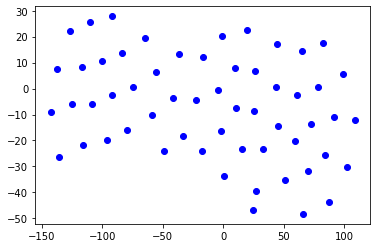

In [236]:
import matplotlib.pyplot as plt
plt.scatter(Xs_new[:,0], Xs_new[:,1],c='b')
plt.show()

In [6]:
Xs

array([[-0.36806265, -0.27473503, -0.2798349 , ..., -0.31364439,
        -0.29677174, -0.22209119],
       [-0.36806265, -0.27473503, -0.2798349 , ..., -0.31364439,
        -0.29677174, -0.22209119],
       [ 1.06507306, -0.27473503, -0.2798349 , ..., -0.31364439,
        -0.29677174, -0.22209119],
       ...,
       [-0.36806265, -0.27473503, -0.2798349 , ..., -0.31364439,
        -0.29677174, -0.22209119],
       [-0.36806265,  2.03070409, -0.2798349 , ...,  2.01155845,
        -0.29677174, -0.22209119],
       [-0.36806265, -0.27473503, -0.2798349 , ..., -0.31364439,
        -0.29677174, -0.22209119]])

## Test TCA

In [ ]:
tca = TCA(kernel_type='linear', dim=30, lamb=1, gamma=1)
acc, ypre = tca.fit_predict(Xs, Ys, Xt, Yt)
print(f'The accuracy of TCA is: {acc:.4f}')

The accuracy of TCA is: 0.4562


## Test BDA

In [ ]:
bda = BDA(kernel_type='primal', dim=30, lamb=1, mu=0.5, mode='BDA', gamma=1, estimate_mu=False)
acc, ypre, list_acc = bda.fit_predict(Xs, Ys, Xt, Yt)
print(f'The accuracy of BDA is: {acc:.4f}')

BDA iteration [1/10]: Acc: 0.4666
BDA iteration [2/10]: Acc: 0.4593
BDA iteration [3/10]: Acc: 0.4656
BDA iteration [4/10]: Acc: 0.4624
BDA iteration [5/10]: Acc: 0.4666
BDA iteration [6/10]: Acc: 0.4666
BDA iteration [7/10]: Acc: 0.4656
BDA iteration [8/10]: Acc: 0.4656
BDA iteration [9/10]: Acc: 0.4656
BDA iteration [10/10]: Acc: 0.4656
The accuracy of BDA is: 0.4656


## Test WBDA

In [ ]:
wbda = BDA(kernel_type='primal', dim=30, lamb=1, mode='WBDA', gamma=1, estimate_mu=False)
acc, ypre, list_acc = wbda.fit_predict(Xs, Ys, Xt, Yt)
print(f'The accuracy of WBDA is: {acc:.4f}')

WBDA iteration [1/10]: Acc: 0.4666
WBDA iteration [2/10]: Acc: 0.4635
WBDA iteration [3/10]: Acc: 0.4520
WBDA iteration [4/10]: Acc: 0.4635
WBDA iteration [5/10]: Acc: 0.4603
WBDA iteration [6/10]: Acc: 0.4624
WBDA iteration [7/10]: Acc: 0.4572
WBDA iteration [8/10]: Acc: 0.4624
WBDA iteration [9/10]: Acc: 0.4614
WBDA iteration [10/10]: Acc: 0.4593
The accuracy of WBDA is: 0.4593


In [233]:
import pandas as pd

data_source = pd.read_csv('./car-euro-edited.csv', header=0)
data_target = pd.read_csv('./car-japan-edited.csv', header=0)
Xs = pd.DataFrame(data_source, columns=['Weight','Horsepower'],dtype=float)
Ys = data_source[['Selected']].values
Xt = pd.DataFrame(data_target, columns=['Weight','Horsepower'],dtype=float)
Yt = data_target[['Selected']].values

In [195]:
# tca = TCA(kernel_type='linear', dim=15, lamb=1, gamma=1)
# acc, ypre = tca.fit_predict(Xs, Ys, Xt, Yt)
# print(f'The accuracy of TCA is: {acc:.4f}')

bda = BDA(kernel_type='primal', dim=10, lamb=1, mu=0.5, mode='BDA', gamma=1, estimate_mu=False)
acc, ypre, list_acc = bda.fit_predict(Xs, Ys, Xt, Yt)
print(f'The accuracy of BDA is: {acc:.4f}')

BDA iteration [1/10]: Acc: 0.5333
BDA iteration [2/10]: Acc: 0.5333
BDA iteration [3/10]: Acc: 0.5333
BDA iteration [4/10]: Acc: 0.5333
BDA iteration [5/10]: Acc: 0.5333
BDA iteration [6/10]: Acc: 0.5333
BDA iteration [7/10]: Acc: 0.5333
BDA iteration [8/10]: Acc: 0.5333
BDA iteration [9/10]: Acc: 0.5333
BDA iteration [10/10]: Acc: 0.5333
The accuracy of BDA is: 0.5333


In [216]:
tca = TCA(kernel_type='linear', dim=10, lamb=1, gamma=1)
Xs_new, Xt_new = tca.fit(Xs, Xt)
Xt_new

array([[-9.99985695e-01,  4.99544243e-03, -7.27421801e-05,
         6.61206482e-04,  8.55296868e-04, -3.88434820e-04,
        -1.90630220e-04,  1.46952925e-03,  3.20397690e-04,
         1.76071335e-04],
       [-9.99985695e-01,  4.99544243e-03, -7.27421801e-05,
         6.61206482e-04,  8.55296868e-04, -3.88434820e-04,
        -1.90630220e-04,  1.46952925e-03,  3.20397690e-04,
         1.76071335e-04],
       [-9.99985695e-01,  4.99544243e-03, -7.27421801e-05,
         6.61206482e-04,  8.55296868e-04, -3.88434820e-04,
        -1.90630220e-04,  1.46952925e-03,  3.20397690e-04,
         1.76071335e-04],
       [-9.99985695e-01,  4.99544243e-03, -7.27421801e-05,
         6.61206482e-04,  8.55296868e-04, -3.88434820e-04,
        -1.90630220e-04,  1.46952925e-03,  3.20397690e-04,
         1.76071335e-04],
       [-9.99985695e-01,  4.99544243e-03, -7.27421801e-05,
         6.61206482e-04,  8.55296868e-04, -3.88434820e-04,
        -1.90630220e-04,  1.46952925e-03,  3.20397690e-04,
         1.

In [1]:
Ys

NameError: name 'Ys' is not defined

In [188]:
print(list(ypre))
print(list(data_target['Selected']))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


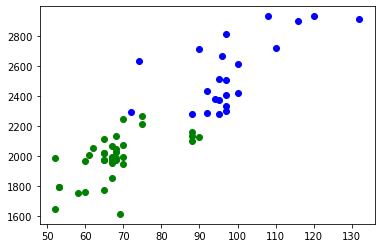

In [189]:
data1 = data_target[data_target['Selected']==1]
data2 = data_target[data_target['Selected']==0]
import matplotlib.pyplot as plt
plt.scatter(data1['Horsepower'], data1['Weight'],c='b')
plt.scatter(data2['Horsepower'], data2['Weight'],c='g')
plt.show()

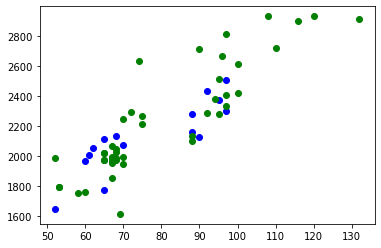

In [196]:
data1 = data_target[ypre==1]
data2 = data_target[ypre==0]
import matplotlib.pyplot as plt
plt.scatter(data1['Horsepower'], data1['Weight'],c='b')
plt.scatter(data2['Horsepower'], data2['Weight'],c='g')
plt.show()

In [185]:
data_source

,Model,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Year,Origin,Selected
0,volkswagen 1131 deluxe sedan,26.0,4,97,46,1835,20.5,1970,Europe,0
1,volkswagen super beetle,26.0,4,97,46,1950,21.0,1973,Europe,0
2,volkswagen rabbit custom diesel,43.1,4,90,48,1985,21.5,1978,Europe,0
3,vw rabbit c (diesel),44.3,4,90,48,2085,21.7,1980,Europe,0
4,vw dasher (diesel),43.4,4,90,48,2335,23.7,1980,Europe,0
5,fiat 128,29.0,4,68,49,1867,19.5,1973,Europe,0
6,vw pickup,44.0,4,97,52,2130,24.6,1982,Europe,0
7,volkswagen type 3,23.0,4,97,54,2254,23.5,1972,Europe,0
8,renault 5 gtl,36.0,4,79,58,1825,18.6,1977,Europe,0
9,volkswagen model 111,27.0,4,97,60,1834,19.0,1971,Europe,0








Try another dataset